In [1]:
!nvidia-smi

Wed Jun 11 21:08:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10                     On  |   00000000:06:00.0 Off |                    0 |
|  0%   47C    P0             59W /  150W |    6309MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import os

from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import bitsandbytes as bnb
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
    pipeline,
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel

/home/ubuntu/ssne-mm/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MODEL_NAME = "microsoft/phi-1_5"
LORA_MODEL_OUTPUT_DIR = "./hate-speech-lora-model"
TRAIN_FILE = "data/hate_train.csv"
TEST_FILE = "data/hate_test_data.txt"
PREDICTION_FILE = "pred.csv"

SEED = 42 # reproductivity

In [4]:
import pandas as pd

df_train_full = pd.read_csv(TRAIN_FILE)
with open(TEST_FILE, 'r', encoding='utf-8') as f:
    test_texts = [line.strip() for line in f]
df_test = pd.DataFrame(test_texts, columns=['sentence'])

print(f"Loaded {len(df_train_full)} training samples and  test samples.")





train_df, val_df = train_test_split(df_train_full, test_size=0.15, random_state=42, stratify=df_train_full['label'])

# experimental
train_df = train_df.iloc[:2000].reset_index(drop=True)
val_df = val_df.iloc[:400].reset_index(drop=True)

print(train_df.head())
print()
print(train_df['label'].value_counts())

raw_datasets = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'validation': Dataset.from_pandas(val_df),
    'test': Dataset.from_pandas(df_test)
})

Loaded 10041 training samples and  test samples.
                                            sentence  label
0  @anonymized_account Najgorzej jak polityk mien...      0
1  @anonymized_account I tak oto chrześcijańska p...      1
2  @anonymized_account Sam się sobie dziwie ale n...      0
3  RT @anonymized_account Przypominam.  Kto taśma...      0
4  @anonymized_account Reklamy szamponu na TT jes...      0

label
0    1823
1     177
Name: count, dtype: int64


In [5]:
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.float16,
# )

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    trust_remote_code=True,
    device_map="auto"
)
model.config.use_cache = False

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


In [6]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "dense",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

trainable params: 3,145,728 || all params: 1,421,416,448 || trainable%: 0.2213


In [7]:
PROMPT_TEMPLATE_FINETUNE = (
    "Przeanalizuj poniższy tekst i określ, czy jest to mowa nienawiści. "
    "Odpowiedz '1' dla mowy nienawiści lub '0' w przeciwnym razie. "
    "Tekst: {text}\n"
    "Odpowiedź: {label_str}{eos_token}"
)


def format_dataset_for_finetuning(examples):
    texts = examples['sentence']
    labels_int = examples['label']
    formatted_prompts = []
    for text, label_int in zip(texts, labels_int):
        label_str = str(label_int)
        formatted_prompts.append(
            PROMPT_TEMPLATE_FINETUNE.format(
                text=text,
                label_str=label_str,
                eos_token=tokenizer.eos_token
            )
        )
    return {"formatted_prompt": formatted_prompts}

def tokenize_function(examples):
    return tokenizer(
        examples["formatted_prompt"],
        truncation=True,
        max_length=180,
        padding="max_length"
    )

tokenized_datasets = DatasetDict()

for split in ['train', 'validation']:
    formatted_data = raw_datasets[split].map(format_dataset_for_finetuning, batched=True, num_proc=4)
    tokenized_datasets[split] = formatted_data.map(
        tokenize_function,
        batched=True,
        remove_columns=raw_datasets[split].column_names + ["formatted_prompt"]
    )

def set_labels(examples):
    examples["labels"] = examples["input_ids"].copy()
    return examples

tokenized_datasets['train'] = tokenized_datasets['train'].map(set_labels, batched=True)
tokenized_datasets['validation'] = tokenized_datasets['validation'].map(set_labels, batched=True)


print("\nPróbka danych po tokenizacji z nowym promptem:")
print(tokenizer.decode(tokenized_datasets["train"][0]['input_ids'], skip_special_tokens=False))

Map: 100%|██████████| 400/400 [00:00<00:00, 9508.68 examples/s]


Próbka danych po tokenizacji z nowym promptem:
Przeanalizuj poniższy tekst i określ, czy jest to mowa nienawiści. Odpowiedz '1' dla mowy nienawiści lub '0' w przeciwnym razie. Tekst: @anonymized_account Najgorzej jak polityk mieniący się konserwatystą nie odróżnia konserwatysty od konserwy.
Odpowiedź: 0<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


In [8]:
training_args = TrainingArguments(
    output_dir=LORA_MODEL_OUTPUT_DIR,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    weight_decay=0.01,
    num_train_epochs=1,
    logging_steps=10,
    save_steps=100,
    eval_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    save_total_limit=2,
    fp16=True,
    report_to="wandb",
    run_name="hate-speech-lora-finetuning",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
)

/tmp/ipykernel_56468/1432817989.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [9]:
!nvidia-smi

Wed Jun 11 21:08:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10                     On  |   00000000:06:00.0 Off |                    0 |
|  0%   46C    P0             60W /  150W |    8182MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
print("\nRozpoczynanie treningu...")
trainer.train()

best_model_path = LORA_MODEL_OUTPUT_DIR+ "/best"
trainer.save_model(best_model_path)
print(f"Najlepszy model (adaptery LoRA) zapisany w: {best_model_path}")


Rozpoczynanie treningu...


wandb: Currently logged in as: 01178563 (01178563-warsaw-information-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/ubuntu/ssne-mm/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
100,1.223700,1.206696
200,1.204100,1.178937


/home/ubuntu/ssne-mm/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/ubuntu/ssne-mm/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Najlepszy model (adaptery LoRA) zapisany w: ./hate-speech-lora-model/best


In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from peft import PeftModel
from tqdm import tqdm

Załadowano model z adapterami z: ./hate-speech-lora-model/best


Ewaluacja na zbiorze walidacyjnym: 100%|██████████| 400/400 [01:42<00:00,  3.92it/s]


--- Wyniki ewaluacji na zbiorze walidacyjnym ---
Dokładność (Accuracy): 0.8700

Raport klasyfikacji:
                     precision    recall  f1-score   support

Not Hate-Speech (0)       0.89      0.97      0.93       359
    Hate-Speech (1)       0.00      0.00      0.00        41

           accuracy                           0.87       400
          macro avg       0.45      0.48      0.47       400
       weighted avg       0.80      0.87      0.84       400


Macierz pomyłek:


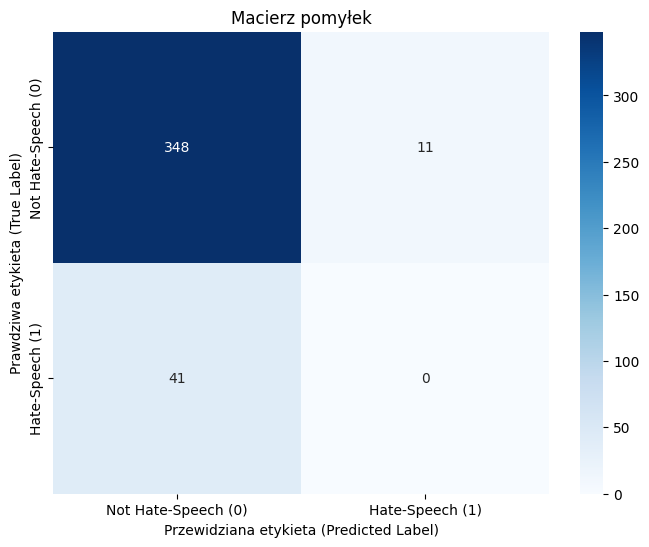

In [13]:
PROMPT_TEMPLATE_INFERENCE = (
    "Przeanalizuj poniższy tekst i określ, czy jest to mowa nienawiści. "
    "Odpowiedz '1' dla mowy nienawiści lub '0' w przeciwnym razie. "
    "Tekst: {text}\n"
    "Odpowiedź: "
)


base_model_for_inference = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    trust_remote_code=True,
    device_map="auto"
)

inference_model = PeftModel.from_pretrained(base_model_for_inference, best_model_path)
print(f"Załadowano model z adapterami z: {best_model_path}")

inference_model.eval()

y_true = []
y_pred = []


for sample in tqdm(raw_datasets['validation'], desc="Ewaluacja na zbiorze walidacyjnym"):
    text = sample['sentence']
    true_label = sample['label']

    y_true.append(true_label)

    prompt = PROMPT_TEMPLATE_INFERENCE.format(
        text=text
    )    
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    with torch.no_grad():
        generate_ids = inference_model.generate(
            **inputs,
            max_new_tokens=3,
            pad_token_id=tokenizer.eos_token_id
        )

    output_text = tokenizer.decode(generate_ids[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True).strip()

    if output_text in ['0', '1']:
        prediction = int(output_text)
    else:
        prediction = 1 - true_label

    y_pred.append(prediction)

print("\n--- Wyniki ewaluacji na zbiorze walidacyjnym ---")

accuracy = accuracy_score(y_true, y_pred)
print(f"Dokładność (Accuracy): {accuracy:.4f}")

print("\nRaport klasyfikacji:")
print(classification_report(y_true, y_pred, target_names=['Not Hate-Speech (0)', 'Hate-Speech (1)']))

print("\nMacierz pomyłek:")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Not Hate-Speech (0)', 'Hate-Speech (1)'],
    yticklabels=['Not Hate-Speech (0)', 'Hate-Speech (1)']
)
plt.ylabel('Prawdziwa etykieta (True Label)')
plt.xlabel('Przewidziana etykieta (Predicted Label)')
plt.title('Macierz pomyłek')
plt.show()
